In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
og_data = pd.read_csv('data.csv')

In [3]:
#there are 5000 shot_made_flag null values, that's our test data, the rest is training data
test = og_data.loc[og_data['shot_made_flag'].isnull()]
data = og_data.loc[og_data['shot_made_flag'].notnull()]

#feature engineering
data.seconds_remaining = pd.to_timedelta(data.seconds_remaining, unit='s')
data.minutes_remaining = pd.to_timedelta(data.minutes_remaining, unit='m')
data['time_remaining'] = data.minutes_remaining+data.seconds_remaining
data.game_date = pd.to_datetime(data.game_date)
data['home_game'] = data.matchup.apply(lambda x: 1 if 'vs.' in x else 0)

# Create features for shot angle and distance from hoop
data['angle'] = np.degrees(np.arctan(data['loc_y'] / data['loc_x']))
data['distance'] = np.sqrt(np.power(data['loc_x'], 2) + np.power(data['loc_y'], 2))
# Note that distance from hoop is based on the position values and so does not correspond to a unit

data.describe()

game_event_id       game_id           lat         loc_x         loc_y  \
count   25697.000000  2.569700e+04  25697.000000  25697.000000  25697.000000   
mean      249.348679  2.474109e+07     33.953043      7.148422     91.257345   
std       149.778520  7.738108e+06      0.088152    110.073147     88.152106   
min         2.000000  2.000001e+07     33.253300   -250.000000    -44.000000   
25%       111.000000  2.050006e+07     33.884300    -67.000000      4.000000   
50%       253.000000  2.090034e+07     33.970300      0.000000     74.000000   
75%       367.000000  2.960027e+07     34.040300     94.000000    160.000000   
max       653.000000  4.990009e+07     34.088300    248.000000    791.000000   

                lon       minutes_remaining        period      playoffs  \
count  25697.000000                   25697  25697.000000  25697.000000   
mean    -118.262652  0 days 00:04:53.207767      2.520800      0.146243   
std        0.110073  0 days 00:03:27.148523      1.151626      0.353356   
min     -118.519800         0 days 00:00:00      1.000000      0.000000   
25%     -118.336800         0 days 00:02:00      1.000000      0.000000   
50%     -118.269800         0 days 00:05:00      3.000000      0.000000   
75%     -118.175800         0 days 00:08:00      3.000000      0.000000   
max     -118.021800         0 days 00:11:00      7.000000      1.000000   

            seconds_remaining  shot_distance  shot_made_flag       team_id  \
count                   25697   25697.000000    25697.000000  2.569700e+04   
mean   0 days 00:00:28.311553      13.457096        0.446161  1.610613e+09   
std    0 days 00:00:17.523391       9.388725        0.497103  0.000000e+00   
min           0 days 00:00:00       0.000000        0.000000  1.610613e+09   
25%           0 days 00:00:13       5.000000        0.000000  1.610613e+09   
50%           0 days 00:00:28      15.000000        0.000000  1.610613e+09   
75%           0 days 00:00:43      21.000000        1.000000  1.610613e+09   
max           0 days 00:00:59      79.000000        1.000000  1.610613e+09   

            shot_id          time_remaining     home_game         angle  \
count  25697.000000                   25697  25697.000000  21376.000000   
mean   15328.166946  0 days 00:05:21.519321      0.485854      4.050841   
std     8860.462397  0 days 00:03:28.311076      0.499810     52.335509   
min        2.000000         0 days 00:00:00      0.000000    -90.000000   
25%     7646.000000         0 days 00:02:21      0.000000    -44.550033   
50%    15336.000000         0 days 00:05:04      0.000000      3.247343   
75%    22976.000000         0 days 00:08:19      1.000000     51.119683   
max    30697.000000         0 days 00:11:54      1.000000     90.000000   

           distance  
count  25697.000000  
mean     138.668288  
std       95.060918  
min        0.000000  
25%       53.935146  
50%      154.155765  
75%      211.567956  
max      791.818792

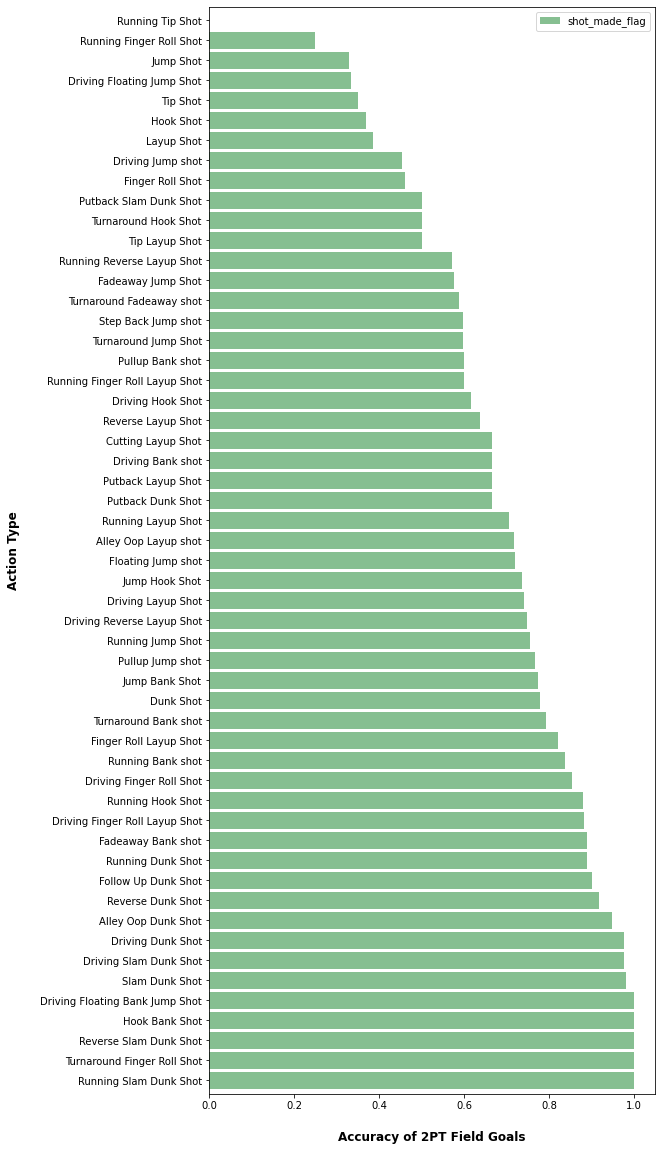

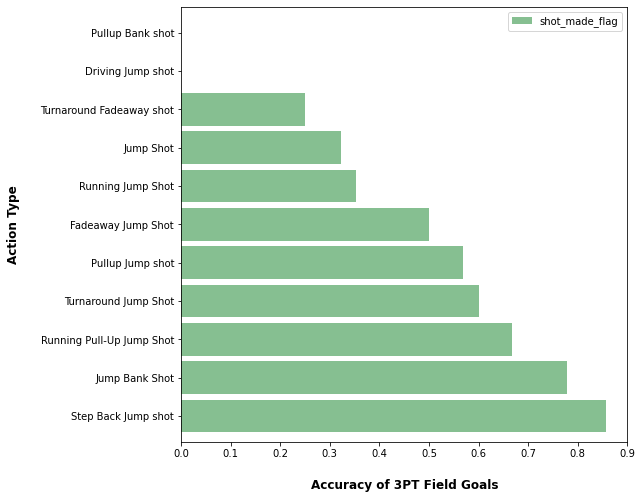

In [4]:
#action type accuracy
groups = data[['action_type','shot_type','shot_made_flag']].groupby(['action_type','shot_type'], as_index=False).mean()

parameters = {
    '2PT Field Goal': {
        'figsize': {
            'y': 20
        }
    },
    '3PT Field Goal': {
        'figsize': {
            'y': 8
        }
    }
}

#this plot might get merged into a single one
for n, g in groups.groupby('shot_type'):
    ax = g.sort_values(by='shot_made_flag', ascending=False).plot(kind='barh', x='action_type', y='shot_made_flag', figsize=(8, parameters[n]['figsize']['y']), color='#86bf91', zorder=2, width=0.85)
    # Set x-axis label
    ax.set_xlabel('Accuracy of ' + n + 's', labelpad=20, weight='bold', size=12)
    # Set y-axis label
    ax.set_ylabel('Action Type', labelpad=20, weight='bold', size=12);

In [5]:
#drawing the court
from matplotlib.patches import Circle, Rectangle, Arc; import numpy as np;

#source: http://savvastjortjoglou.com/nba-shot-sharts.html
def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax


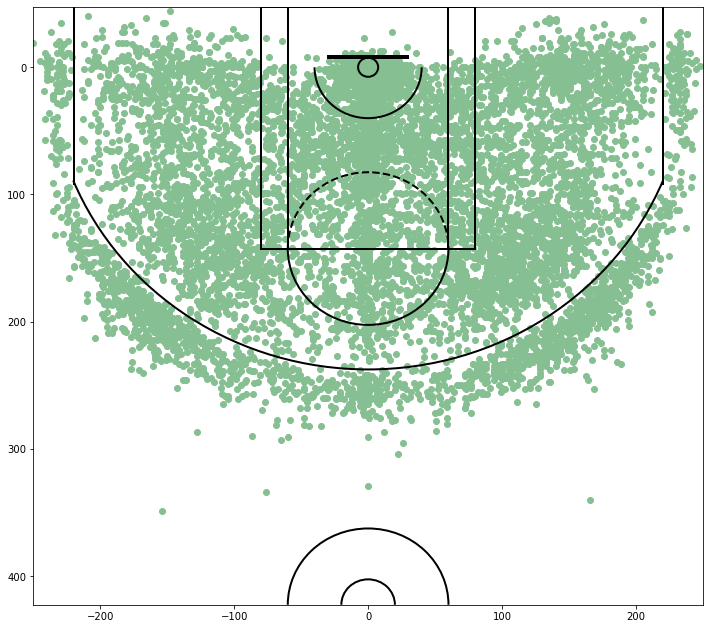

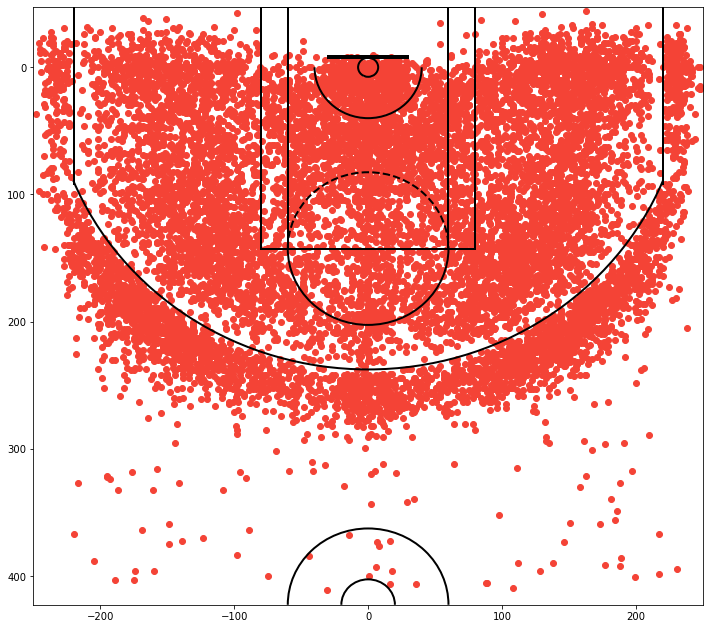

In [6]:
#shots made vs shots failed
parameters = [{
    'shot_made_flag': 1,
    'color': '#86bf91'
}, {
    'shot_made_flag': 0,
    'color': '#f44336'
}]

for x in range(2):
    plt.figure(figsize=(12,11))
    shots_made = data.loc[data['shot_made_flag'] == parameters[x]['shot_made_flag']]
    # plt.scatter(data.loc_x, data.loc_y, c=np.where((data['shot_made_flag'] == 1), 'g', 'r'))
    plt.scatter(shots_made.loc_x, shots_made.loc_y, color=parameters[x]['color'])
    draw_court()
    # Adjust plot limits to just fit in half court
    plt.xlim(-250,250)
    # Descending values along th y axis from bottom to top
    # in order to place the hoop by the top of plot
    plt.ylim(422.5, -47.5)
    # get rid of axis tick labels
    # plt.tick_params(labelbottom=False, labelleft=False)
    plt.show();

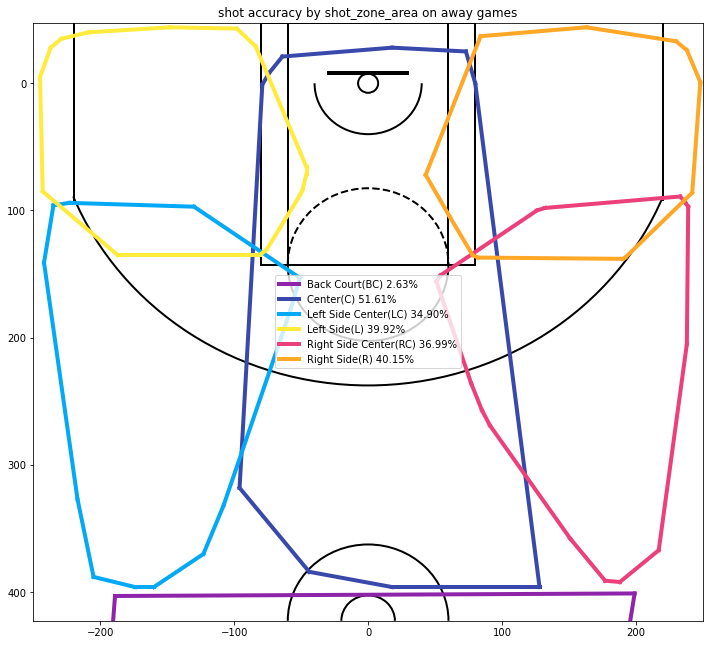

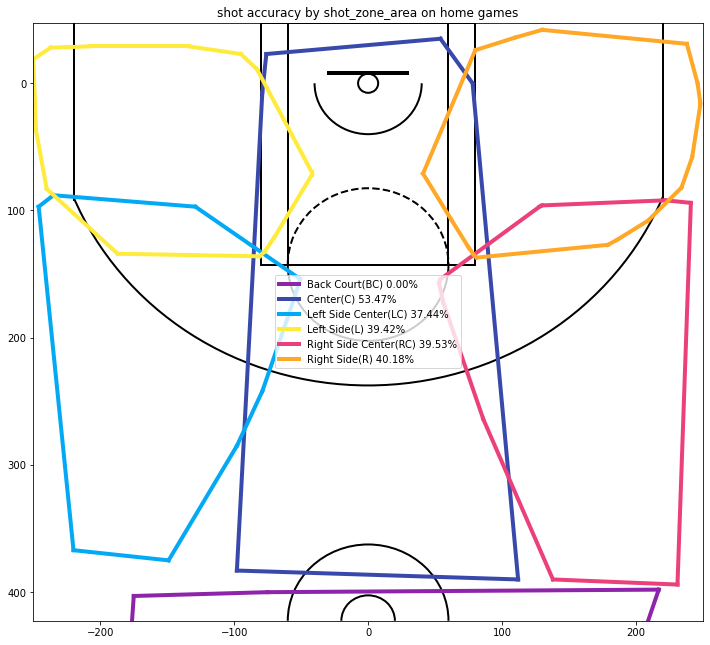

In [7]:
#shot accuracy by home or away games
from scipy.spatial import ConvexHull, convex_hull_plot_2d; from matplotlib.lines import Line2D;

colors = {
    'Back Court(BC)': '#8e24aa', #purple
    'Center(C)': '#3949ab', #indigo
    'Left Side Center(LC)': '#03a9f4', #light blue
    'Left Side(L)': '#ffeb3b', #yellow
    'Right Side Center(RC)': '#ec407a', #pink
    'Right Side(R)': '#ffa726' #orange
}

home_or_away_str = ['away', 'home']

for n, g in data.groupby(['home_game'], as_index=False):
    sub_data = g[['shot_zone_area', 'loc_x','loc_y', 'shot_made_flag']]
    hulls = []
    legends = []
    for n2, g2 in sub_data.groupby('shot_zone_area', as_index=False):
        points = g2[['loc_x','loc_y']].to_numpy()
        hulls.append({ 
            'name': n2, 
            'points': points,
            'hull': None if points.size < 3 else ConvexHull(points)
        })
        legends.append(Line2D([0], [0], color=colors[n2], lw=4, label=n2 + ' ' + '{:.2%}'.format(g2['shot_made_flag'].mean())))
    plt.figure(figsize=(12,11))
    ax = draw_court()
    for hull in hulls:
        # plt.text(hull['centroid'][0], hull['centroid'][1], hull['accuracy'], fontsize=12)
        if hull['hull'] is not None:
            for simplex in hull['hull'].simplices:
                plt.plot(hull['points'][simplex, 0], hull['points'][simplex, 1], 'k-', color=colors[hull['name']], linewidth=4)

    ax.legend(handles=legends, loc='center')
        

    plt.xlim(-250,250)
    # # Descending values along th y axis from bottom to top
    # # in order to place the hoop by the top of plot
    plt.ylim(422.5, -47.5)
    # # get rid of axis tick labels
    # # plt.tick_params(labelbottom=False, labelleft=False)
    plt.title('shot accuracy by shot_zone_area on ' + home_or_away_str[n] + ' games')
    plt.show();

In [8]:
## Perform DBSCAN clustering
X = data[['loc_x', 'loc_y']]
X = StandardScaler().fit_transform(X)
db = DBSCAN(eps=0.07, min_samples=50).fit(X)

In [9]:
labels = db.labels_
data["cluster"] = labels

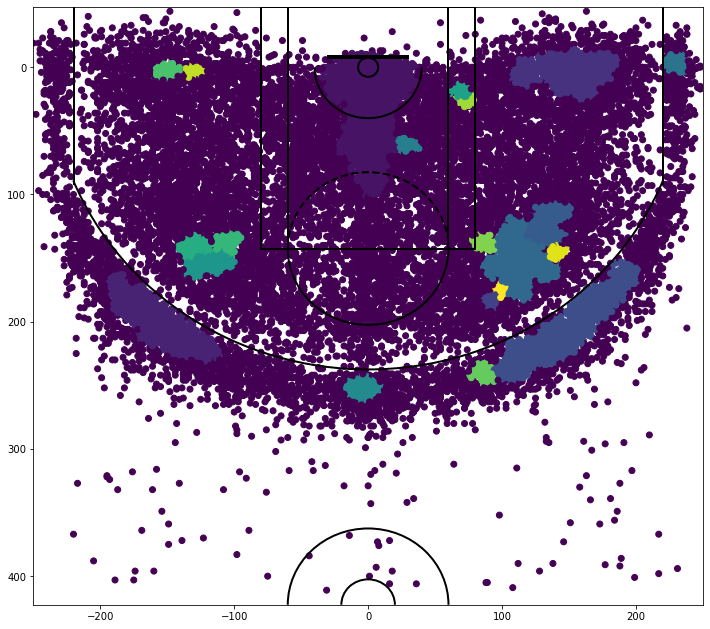

In [10]:
plt.figure(figsize=(12,11))
# plt.scatter(data.loc_x, data.loc_y, c=np.where((data['shot_made_flag'] == 1), 'g', 'r'))
plt.scatter(data.loc_x, data.loc_y, c=data.cluster)
draw_court()
# Adjust plot limits to just fit in half court
plt.xlim(-250,250)
# Descending values along th y axis from bottom to top
# in order to place the hoop by the top of plot
plt.ylim(422.5, -47.5)
# get rid of axis tick labels
# plt.tick_params(labelbottom=False, labelleft=False)
plt.show();

In [13]:
data['game_date'] = pd.to_datetime(data['game_date'])
test['game_date'] = pd.to_datetime(test['game_date'])
test.sort_values(by=['game_date'], inplace=True, ascending=True)

shot_made_corr_df = pd.DataFrame()

for test_idx in test.index:
    shot_made_corr_df = shot_made_corr_df.append(data[data['game_date'] < test['game_date'][test_idx]].corr()['shot_made_flag'], ignore_index=True)

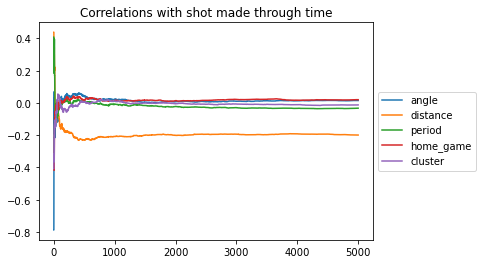

In [14]:
shot_made_corr_df[['angle', 'distance', 'period', 'home_game', 'cluster']].plot.line()
plt.title('Correlations with shot made through time', color='black')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()